## basic config

In [1]:
import torch
import os
torch.cuda.device_count()

1

In [2]:

def align_faces_2(root_path):
    import os 
    current_path = os.getcwd()
    temp_path = "/home/bean/stylegan3-editing"
    os.chdir(temp_path)
    command =f"""python prepare_data/preparing_faces_parallel.py \
                --mode align \
                --root_path  {root_path} 
                """
    import subprocess
    subprocess.run(command, shell=True)
    os.chdir(current_path)

In [3]:
# DRAGVIDEO_ROOT_PATH = "/Ext_4T_SSD/ASHOK/"
DRAGVIDEO_ROOT_PATH = "/home/bean/"

# keep matching encoder,SG as pairt 
old = {"encoder":  f"{DRAGVIDEO_ROOT_PATH}DragVideo/DragGAN/_PTI/pretrained_models/e4e_ffhq_encode.pt",
       "SG": f"{DRAGVIDEO_ROOT_PATH}DragVideo/DragGAN/_PTI/pretrained_models/ffhq.pkl",
       "model_name":"stylegan2",
       "resolution":1024,
       }

new = {"encoder": f"{DRAGVIDEO_ROOT_PATH}DragVideo/Data_store/OLD/model_weights/restyle_e4e_ffhq.pt",
         "SG":  f"{DRAGVIDEO_ROOT_PATH}DragVideo/Data_store/OLD/model_weights/stylegan3_3rdtime_weights/stylegan3-r-ffhq-1024_module.pkl",
         "model_name":"stylegan3",
               "resolution":1024,
         }

new_256 = {"encoder": f"{DRAGVIDEO_ROOT_PATH}DragVideo/Data_store/OLD/model_weights/restyle_e4e_ffhq.pt",
         "SG":  f"{DRAGVIDEO_ROOT_PATH}DragVideo/Data_store/OLD/Stylegan3_1_files/stylegan3-r-ffhqu-256x256.pkl",
         "model_name":"stylegan3",
         "resolution":256,
         }

videos = {
       "obama": f"{DRAGVIDEO_ROOT_PATH}DragVideo/Data_store/OLD/original_videos/obama.mp4",
       "man_speaking": f"{DRAGVIDEO_ROOT_PATH}DragVideo/Data_store/OLD/original_videos/person_speaking_original.mp4",
       "rahul": f"{DRAGVIDEO_ROOT_PATH}DragVideo/Data_store/OLD/original_videos/rahul.mp4",
       "alien_girl": f"{DRAGVIDEO_ROOT_PATH}DragVideo/Data_store/OLD/original_videos/alien_girl.mp4",
       "mirrAR": f"{DRAGVIDEO_ROOT_PATH}DragVideo/Data_store/OLD/original_videos/mirrAR.mp4",
       "vsauce_frnd":f"{DRAGVIDEO_ROOT_PATH}DragVideo/Data_store/OLD/original_videos/micheal_friendzone.mp4",
       "actress_tan": f"{DRAGVIDEO_ROOT_PATH}DragVideo/Data_store/OLD/original_videos/gadot_tanned_left.mp4",
}

In [4]:
EXPERIMENT_NAME_POSTFIX = "man_speaking"#"aligned_sg3_&_new_e4e_reconstruction_invstep_200_pti_step_450"
models_set = old
Testing =False
# --------------------------------  


import datetime
lazy_config = {
    
    #-----------------
    # often changed
    #-----------------
    "video_path":  videos["man_speaking"],
    "n_frames" : 150,#120,#200,
    "N_STEPS_in_draggan":  "200",
    "editing_function_name":"make_jaw_wider",#"smile", #"smile",#"large_eyes",#"large_eyes" # "make_jaw_wider" # "mouth_wide","up_eyebrows"
        
    # less often changed
    "EXP_NAME": str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+"_"+ EXPERIMENT_NAME_POSTFIX,
    "e4e": models_set['encoder'],
    "stylegan2_ada_ffhq": models_set['SG'],
    "model_name" : models_set['model_name'],
    "IMAGE_SIZE": models_set["resolution"],
    "fps": 24,
    
}

env_config = {
    "DragGAN_dir": f"{DRAGVIDEO_ROOT_PATH}DragVideo/DragGAN",
    "Experiment_base_path":f"{DRAGVIDEO_ROOT_PATH}DragVideo/Data_store/experiments/" ,
    "init_exp_dir_shell_path": f"{DRAGVIDEO_ROOT_PATH}DragVideo/DragGAN/_PTI/init_datadirs.sh",
    "dummy_config_path" : f"{DRAGVIDEO_ROOT_PATH}DragVideo/DragGAN/_PTI/configs/dummy",
    
    
}

#hyper parameters in PTI

hyper_config = {
    "max_pti_steps": 350,
    "first_inv_steps":450,
    "max_images_to_invert": 200,
}

if Testing: 
    hyper_config["max_pti_steps"] = 1#200
    hyper_config["first_inv_steps"] = 1#350
    hyper_config["max_images_to_invert"] = 5
    lazy_config["N_STEPS_in_draggan"] = '150'
    lazy_config["n_frames"] = 1
    lazy_config["editing_function_name"]="smile"
    


# ----------------------------------------------------------------------------------------------


# create experiment data folder structure
Experiment_name = lazy_config["EXP_NAME"]
Experiment_base_path = env_config["Experiment_base_path"]
Experiment_path = os.path.join(Experiment_base_path, Experiment_name)

# change path configs , hyperparameters 
paths_config_dict = {
    #pretrained models
    "e4e": lazy_config["e4e"],
    "stylegan2_ada_ffhq": lazy_config["stylegan2_ada_ffhq"],
    
    # to store tuned stylegan weights
    "checkpoints_dir": os.path.join(Experiment_path,'tuned_SG'),
    # to store latents
    "embedding_base_dir": os.path.join(Experiment_path,'latents'),
    # aligned / processed images
    "input_data_path": os.path.join(Experiment_path,'aligned'),
     "quad_values_path": os.path.join(Experiment_path,'quad_values'),
}



In [5]:
from run_utils import *

init_experiment_dir(Experiment_name,Experiment_base_path,shell_script_path=env_config["init_exp_dir_shell_path"])

# dummy paths_config overwrites the paths_config.py
# dummy_config_path = f"{DRAGVIDEO_ROOT_PATH}DragVideo/DragGAN/_PTI/configs/dummy'
add_dummy_config_from_dict("hyperparameters.py", hyper_config,ROOT_PATH=env_config["dummy_config_path"])

add_dummy_config_from_dict("paths_config.py", paths_config_dict,ROOT_PATH=env_config["dummy_config_path"])



# add all these configs to log.txt
# --------------------------------  
with open(os.path.join(Experiment_path,'log.txt'), 'a') as f:
    import json
    f.write(f"lazy_config: {json.dumps(lazy_config, indent=4)}\n")
    f.write(f"env_config: {json.dumps(env_config, indent=4)}\n")
    f.write(f"hyper_config: {json.dumps(hyper_config, indent=4)}\n")
    
    



In [6]:
# extract frames from video
#==============================================================================

from importlib.machinery import SourceFileLoader
# imports the module from the given path
# video_utils = SourceFileLoader("video_utils","../utils_draggan/video_utils.py").load_module()

ffmpeg_utils = SourceFileLoader("video_utils","../utils_draggan/ffmpeg_utils.py").load_module()
raw_path = os.path.join(Experiment_path, "raw")

# # video_utils.extract_frames(lazy_config['video_path'], raw_path,n_frames=lazy_config['n_frames'])
ffmpeg_utils.ffmpeg.extract_frames(video_path = lazy_config['video_path'],
                                      output_frames_dir = raw_path,
                                      fps = lazy_config['fps'],
                                      first_n_frames = lazy_config['n_frames'],
)

ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.8.2 (GCC) 20140120 (Red Hat 4.8.2-15)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1539667330082/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --disable-doc --disable-openssl --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-cxxflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-lpthread -lm -lz' --enable-zlib --enable-pic --enable-pthreads --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --enable-libfreetype --enable-gnutls --enable-libx264 --enable-libopenh264
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilte

# start

In [7]:
# # # delete this cell 
# # "/home/bean/DragVideo/Data_store/man_speaking/aligned": input_data_path 
# # "/home/bean/DragVideo/Data_store/man_speaking/quad_values", quad_pkl_path

# raw_path = "/home/bean/DragVideo/Data_store/man_speaking/raw"
# pre_process_images(raw_path, IMAGE_SIZE=1024) # o/p: config.input_data_path ,quad pickle dir


In [8]:
from utils.align_data import pre_process_images
pre_process_images(raw_path, IMAGE_SIZE=lazy_config['IMAGE_SIZE']) # o/p: config.input_data_path ,quad pickle dir
#
# align_faces_2(os.path.join(Experiment_path,'raw'))



100%|██████████| 150/150 [02:14<00:00,  1.12it/s]


saving aligned images...
saving quad values...
done!


In [ ]:
from utils.align_data import pre_process_images
from scripts.run_pti import run_PTI

from run_utils_2 import load_generators,export_updated_pickle
from configs import paths_config

use_multi_id_training = True
model_id = run_PTI(use_wandb=False, use_multi_id_training=use_multi_id_training)

generator_type =paths_config.multi_id_model_type if use_multi_id_training else "__"
old_G, new_G = load_generators(model_id, generator_type)
sg_tuned_pkl = export_updated_pickle(new_G,model_id,name = lazy_config["model_name"])

print( f"{sg_tuned_pkl=}") # 'QBUXQCXZGWET'



#get landmarks
landmark_path = f"{DRAGVIDEO_ROOT_PATH}DragVideo/DragGAN/_facial-landmarks-recognition"
os.chdir(landmark_path)
print("pwd",os.getcwd())
import sys
sys.path.append(landmark_path)

from main import landmarks, dict_landmarks,show_landmarks,get_landmarks_dir

# to store landmarks
landmarks_dir =  os.path.join(Experiment_path,'landmarks')
processed_images_dir =  os.path.join(Experiment_path,'aligned')

# generate landmarks for all images in processed_images_dir
get_landmarks_dir(processed_images_dir,landmarks_dir)


# Runs draggan 
all the the below cells use only these config values

In [6]:
# util function to copy an experiment dir
def copy_exp_dir(exp_src):
    import shutil
    exp_dst = exp_src+"_copy"
    shutil.copytree(exp_src, exp_dst)
    return exp_dst
    
# copy_exp_dir("/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg")

In [5]:
#Run first config cells, then run this
if True:
    # just to run draggan seperately
    import os 
    a = "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform"
    b = "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"
    Experiment_path = a# f"/home/bean/DragVideo/Data_store/experiments/{lazy_config['EXP_NAME']}"	
    sg_tuned_pkl = b #new["SG"]


    lazy_config["N_STEPS_in_draggan"]="100"
    lazy_config["editing_function_name"]= "make_jaw_wider"#smile"
    lazy_config["IMAGE_SIZE"]="1024"
    
    
    
    from importlib.machinery import SourceFileLoader
    # imports the module from the given path
    # video_utils = SourceFileLoader("video_utils","../utils_draggan/video_utils.py").load_module()

    ffmpeg_utils = SourceFileLoader("video_utils","../utils_draggan/ffmpeg_utils.py").load_module()

# /home/bean/DragVideo/Data_store/experiments/sept_1/latents/0.pt
# /home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_frnd_120_frames_wide_nose_with_border/latents/barcelona/PTI/000/0.pt

In [6]:
# lazy_config["N_STEPS_in_draggan"]="70"
# # sg_tuned_pkl = "/home/bean/DragVideo/Data_store/experiments/2023-09-07_17-15-54_actress_smile/tuned_SG/stylegan3_JTAGRGHASFMO.pkl"
# sg_tuned_pkl = "/home/bean/DragVideo/Data_store/experiments/2023-09-07_22-53-31_man_speaking/tuned_SG/stylegan2_XKCPTPFPIVZT.pkl"

In [6]:
# clean all data from gpu
import torch
torch.cuda.empty_cache()

os.chdir(env_config["DragGAN_dir"])
import subprocess

print(f"sg_tuned_pkl: {sg_tuned_pkl}")

subprocess.call(['python', '_run_dragvideo.py',
                 '--Experiment_path', Experiment_path,
                 '--N_STEPS',       lazy_config["N_STEPS_in_draggan"],
                 '--CHECKPOINT_PATH', sg_tuned_pkl,
                 "--MAX_SIZE",      str(lazy_config["IMAGE_SIZE"]),
                 "--editing_function_name",lazy_config["editing_function_name"],
])
                #  "--verbose",       "False"])


sg_tuned_pkl: /home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl
editing_function_name: make_jaw_wider
Total 150 images to be processed
intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


  0%|          | 0/100 [00:00<?, ?it/s]/home/bean/.conda/envs/stylegan3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}


100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/tuned_SG/stylegan2_VSSZRRDEEDDP.pkl"... Done.
()
{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'img_resolution': 1024, 'img_channels': 3, 'mapping_kwargs': {'num_layers': 8, 'embed_features': None, 'layer_features': None, 'activation': 'lrelu', 'lr_multiplier': 0.01, 'w_avg_beta': 0.995}, 'synthesis_kwargs': {'channel_base': 32768, 'channel_max': 512, 'num_fp16_res': 4, 'conv_clamp': 256, 'architecture': 'skip', 'resample_filter': [1, 3, 3, 1], 'use_noise': True, 'activation': 'lrelu'}}


 31%|███       | 31/100 [00:20<00:50,  1.36it/s]

In [14]:
# empty catched data
import torch
torch.cuda.empty_cache()

# post processing

In [23]:
lazy_config= {}
lazy_config['video_path'] =  "/home/bean/DragVideo/Data_store/OLD/original_videos/person_speaking_original.mp4"
Experiment_path = "/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform"

In [24]:
import os
from tqdm import tqdm
os.getcwd()
# import importlib
# importlib.reload(ffmpeg_utils)

'/home/bean/DragVideo/DragGAN/_PTI'

In [25]:

from utils import de_alignment 
put_back_the_edited_image = de_alignment.put_back_the_edited_image


In [28]:
def paste_edited_faces_back(dir_path,edited_dir='after_drag',save_dir='after_drag_pasted'):
    raw_dir = os.path.join(dir_path,'raw')
    edited_dir = os.path.join(dir_path,edited_dir)
    quad_dir = os.path.join(dir_path,'quad_values')
    save_dir = os.path.join(dir_path,save_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # get names from edited_dir
    names = [name.split('.')[0] for name in os.listdir(edited_dir)]
    extension = '.png'
    for name in tqdm(names):
        
        # raw_image = os.path.join(raw_dir,name+'.png')
        # edited_image = os.path.join(edited_dir,name+'.png')
        # quad_path = os.path.join(quad_dir,name+'.pkl')
        # save_path = os.path.join(save_dir,name+'.png')
        
        raw_image = os.path.join(raw_dir,name+extension)
        edited_image = os.path.join(edited_dir,name+extension)
        quad_path = os.path.join(quad_dir,name+'.pkl')
        save_path = os.path.join(save_dir,name+extension)
        
        put_back_the_edited_image(raw_image,edited_image,quad_path,save_path=save_path)


In [29]:
# paste_edited_faces_back(Experiment_path,edited_dir="before_drag",save_dir="before_drag_pasted")
paste_edited_faces_back(Experiment_path,edited_dir="after_drag",save_dir="after_drag_pasted")

100%|██████████| 74/74 [00:20<00:00,  3.70it/s]


In [30]:

from importlib.machinery import SourceFileLoader
# imports the module from the given path
# video_utils = SourceFileLoader("video_utils","../utils_draggan/video_utils.py").load_module()

ffmpeg_utils = SourceFileLoader("video_utils","../utils_draggan/ffmpeg_utils.py").load_module()
# raw_path = os.path.join(Experiment_path, "raw")


In [31]:
lazy_config['fps'] =24

In [33]:
# =============================================================================
# using ffmpeg to make video
# =============================================================================
before_drag_pasted_dir = os.path.join(Experiment_path,'before_drag_pasted')
after_drag_pasted_dir = os.path.join(Experiment_path,'after_drag_pasted')
videos_dir = os.path.join(Experiment_path,'videos')

# ffmpeg_utils.ffmpeg.make_video(before_drag_pasted_dir,
#                                video_name="pre_drag_full",
#                                video_dir=videos_dir,
#                                fps=lazy_config['fps'],
#                                  )
ffmpeg_utils.ffmpeg.make_video(after_drag_pasted_dir,
                                 video_name="post_drag_full",
                                    video_dir=videos_dir,
                                    fps=lazy_config['fps'],
                                    ext="png"
                                    )


ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.8.2 (GCC) 20140120 (Red Hat 4.8.2-15)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1539667330082/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --disable-doc --disable-openssl --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-cxxflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-lpthread -lm -lz' --enable-zlib --enable-pic --enable-pthreads --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --enable-libfreetype --enable-gnutls --enable-libx264 --enable-libopenh264
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilte

In [34]:
# =============================================================================
# hstack videos
# =============================================================================

video1= os.path.join(videos_dir,"pre_drag_full.mp4")
video2= os.path.join(videos_dir,"post_drag_full.mp4")

# pre_post_drag_full
# ffmpeg_utils.ffmpeg.hstack_videos(video1,
#                                   video2,
#                                   output_dir=videos_dir,
#                                   output_name="hstack_pre_post_drag_full",
# )

# original_post_drag_full
ffmpeg_utils.ffmpeg.hstack_videos(lazy_config['video_path'],
                                  video2,
                                  output_dir=videos_dir,
                                  output_name="hstack_original_post_drag_full",
)

/home/bean/DragVideo/Data_store/experiments/_save_man_speaking_large_deform/videos/hstack_original_post_drag_full.mp4


ffmpeg version 4.0.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.8.2 (GCC) 20140120 (Red Hat 4.8.2-15)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1539667330082/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --disable-doc --disable-openssl --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-cxxflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-lpthread -lm -lz' --enable-zlib --enable-pic --enable-pthreads --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --enable-libfreetype --enable-gnutls --enable-libx264 --enable-libopenh264
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilte

In [37]:
!pip install molesq

(68, 2)


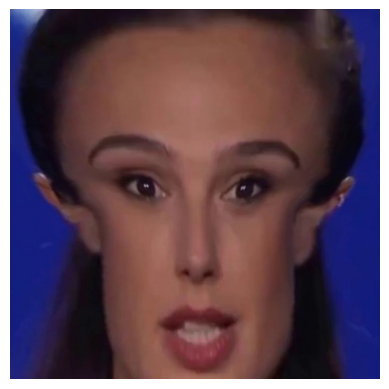

In [225]:
from PIL import Image
from molesq import ImageTransformer
import matplotlib.pyplot as plt
import numpy as np
import pickle

img_path = "/home/bean/DragVideo/Data_store/experiments/2023-09-06_00-38-36_actress_smile/aligned/000.jpg"
landmarks_path = "/home/bean/DragVideo/Data_store/experiments/2023-09-06_00-38-36_actress_smile/landmarks/000.pkl"

img = Image.open(img_path)

img = np.array(img) #(1024, 1024, 3)

#=== load landmarks ===
with open(landmarks_path, 'rb') as f:
    landmarks = pickle.load(f)
    landmarks = np.array(landmarks)[0]
    
print(landmarks.shape)

#=== get control points ===
def get_controls_points(landmarks):
    offset = 50

    points = landmarks[0:17].copy()
    
    # targets = landmarks[0:17].copy()
    # targets[range(0,6)] -= np.array([offset, 0])
    # targets[range(11,17)] += np.array([offset, 0])
    # targets[range(6,11)] -= np.array([0, offset])
    
    centre = np.mean(points, axis=0)
    radius = np.linalg.norm(points[0] - centre)
    
    targets = np.zeros_like(points)
    for i in range(0, 17):
        vec = points[i] - centre
        vec /= np.linalg.norm(vec)
        targets[i] = centre + vec * radius
    return points, targets

#change coordinate system
def change_axis(points,max_y=1024):
    points = np.array(points)
    # max_y = 1024
    x = points[:,0]
    y = points[:,1]
    
    nex_x = max_y - y
    nex_y = x
    return np.array([nex_x,nex_y]).T

old_points, old_targets = get_controls_points(landmarks)
points, targets = change_axis(old_points), change_axis(old_targets)


# Create a transformer object
transformer = ImageTransformer(img, points, targets,color_dim=2,
                                       interp_order=2,)
out = transformer.deform_viewport()



# out = transformer.deform_whole()
plt.imshow(out)
plt.axis('off')
plt.show()

In [226]:
plt.imsave("out.png",out)	

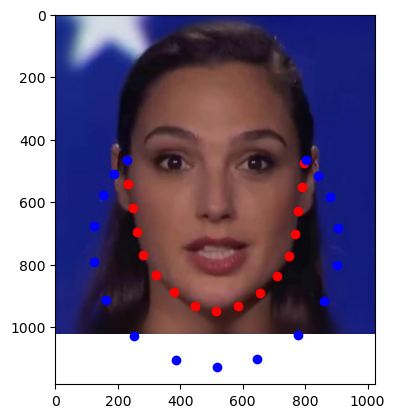

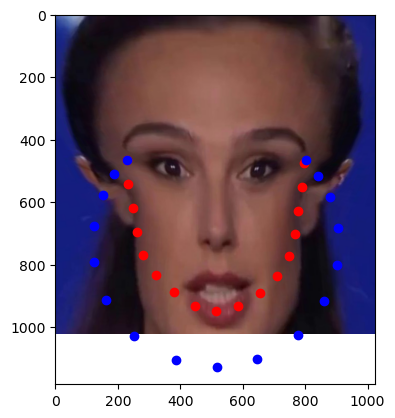

In [222]:
def plot_img(points,targets,img):    #print points, targets on image
    import matplotlib.pyplot as plt

    plt.imshow(img)
    plt.scatter(points[:,0],points[:,1],c='r')
    plt.scatter(targets[:,0],targets[:,1],c='b')
    plt.show()

plot_img(old_points,old_targets,img)
plot_img(old_points,old_targets,out)